In [1]:
#######################
# Import dependencies #
#######################
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [2]:
###################################################
# Python SQL toolkit and Object Relational Mapper #
###################################################
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [3]:
##################################
# create engine to hawaii.sqlite #
##################################
import os
os.chdir("Resources")
engine = create_engine("sqlite:///hawaii.sqlite")
os.chdir("..")

In [4]:
#################################################
# reflect an existing database into a new model #
#################################################
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
##############################################
# View all of the classes that automap found #
##############################################
Base.classes.keys()

['measurement', 'station']

In [6]:
#################################
# Save references to each table #
#################################
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
###################################################
# Create our session (link) from Python to the DB #
###################################################
session = Session(engine)

In [8]:
####################################################
# Inspect the columns and data type for each table #
####################################################
print("-"*20)
inspector = inspect(engine)
for x in inspector.get_table_names():
    print(f'Table: {x}\n{"-"*20}')
    for y in inspector.get_columns(x):
        print(y["name"], y["type"])
    print("-"*20)

--------------------
Table: measurement
--------------------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
--------------------
Table: station
--------------------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT
--------------------


# Exploratory Precipitation Analysis

In [9]:
##############################################
# Find the most recent date in the data set. #
##############################################
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

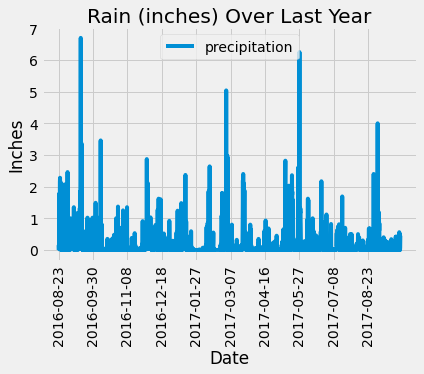

In [10]:
########################################################################
# Design a query to retrieve the last 12 months of precipitation data  #
#    and plot the results.                                             #
# Starting from the most recent data point in the database.            #
# Calculate the date one year from the last date in data set.          #
########################################################################
last_year = session.query(Measurement.date).filter(Measurement.date > '2016-08-23')\
                .order_by(Measurement.date).all()

#################################################################
# Perform a query to retrieve the data and precipitation scores #
#################################################################
date_precip = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= '2016-08-23')\
                .order_by(Measurement.date).all()

#############################################################
# Save the query results as a Pandas DataFrame and set the  #
#    index to the date column                               #
#############################################################
df = pd.DataFrame(date_precip)
df.columns = ["date", "precipitation"]
df = df.dropna()
df.set_index("date")

########################################################
# Use Pandas Plotting with Matplotlib to plot the data #
########################################################
df.plot(kind="line")
x_spaces = np.linspace(0, len(df)-1, num=10)
x_names = [df["date"].tolist()[int(x)] for x in x_spaces]
plt.xticks(x_spaces, x_names, rotation=90)
plt.xlabel("Date")
plt.ylabel("Inches")
plt.title("Rain (inches) Over Last Year")
plt.show()


In [11]:
#############################################################################
# Use Pandas to calcualte the summary statistics for the precipitation data #
#############################################################################
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
########################################################################
# Design a query to calculate the total number stations in the dataset #
########################################################################
session.query(Measurement.station).group_by(Measurement.station).count()

9

In [13]:
#########################################################
# Design a query to find the most active stations       #
#    (i.e. what stations have the most rows?)           #
# List the stations and the counts in descending order. #
#########################################################
session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station).order_by(desc(func.count(Measurement.station))).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
##############################################################
# Using the most active station id from the previous query,  #
#    calculate the lowest, highest, and average temperature. #
##############################################################
session.query(Station.id, func.min(Measurement.prcp), func.max(Measurement.prcp), func.avg(Measurement.prcp))\
    .where(Station.station == 'USC00519281').all()


[(7, 0.0, 11.53, 0.16064353974479206)]

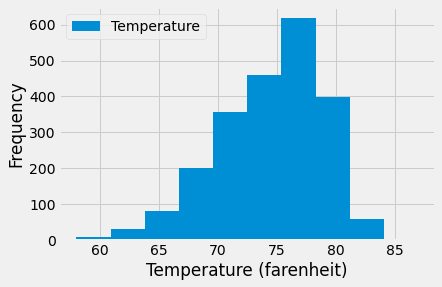

In [20]:
#########################################################################
# Using the most active station id                                      #
# Query the last 12 months of temperature                               #
# observation data for this station and plot the results as a histogram #
#########################################################################
temps = session.query(Station.id, Measurement.tobs).filter(Measurement.date > '2016-08-23').where(Station.id == 7).all()
df = pd.DataFrame(temps)
df.columns = ["Station ID", "Temperature"]
df = df.set_index("Station ID")
df.plot(kind="hist")
plt.xlabel("Temperature (farenheit)")
plt.show()


# Close session

In [21]:
#################
# Close Session #
#################
session.close()
